In [1]:
cd ..

C:\Users\14102\Brown\DATA1030\QIM\Data1030_Final_Prj


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import shap
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
from IPython.display import display, HTML


import xgboost

from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, ParameterGrid, train_test_split

from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
shap.initjs()

In [4]:
# Define Functions

def rmse(y_true, y_pred) -> float:
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

def rmse_unlog(y_true, y_pred):
    tr = 10**y_true
    pr = 10**y_pred
    return rmse(tr, pr)

unlogged_rmse = make_scorer(rmse_unlog, greater_is_better=False)

def MLpipe_KFold_RMSE(feature_matrix, target_var, 
                      preprcr: ColumnTransformer, 
                      init_algo, param_grid: dict, 
                      n_iter: int = 10, n_folds: int = 4,
                      verbose: bool = True, stratify: bool = True, 
                      same_split: bool = False, same_model: bool = False):
    
    model_name = type(init_algo).__name__.lower()
    best_models = []
    test_scores = []
    bsl_test_scores = []
    
    if verbose:
        print('-'*10, model_name.upper(), '-'*10, '\n')
        
    # Repeat for each random state
    for r_state in range(n_iter):
        if same_split:
            r_state_split = 0
        else:
            r_state_split = r_state
            
        if same_model:
            r_state_model = 0
        else:
            r_state_model = r_state
            
        # Split test-other data 20-80
        # Initialize K-fold splitter
        if stratify:
            kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=r_state_split)
            x_other, x_test, y_other, y_test = train_test_split(feature_matrix, target_var, test_size=0.2, 
                                                                random_state=r_state_split, stratify=target_var)
        else:
            kf = KFold(n_splits=n_folds, shuffle=True, random_state=r_state_split)
            x_other, x_test, y_other, y_test = train_test_split(feature_matrix, target_var, test_size=0.2, 
                                                                random_state=r_state_split)
        
        # Create Pipeline
        pipeline = make_pipeline(preprcr, init_algo)
        
        # Add current random_state to param dict. Done in loop to keep in sync with state used for splitting
        if param_grid.get(f'{model_name}__random_state'):
            param_grid[f'{model_name}__random_state'] = [r_state_model]
        
        # I use GridSearchCV to tune hyperparams and fit best model. Using RMSE. Negative b/c scores are implied to mean
        # Greater = better
        g_srch = GridSearchCV(pipeline, param_grid=param_grid, 
                              scoring='neg_root_mean_squared_error', 
                              cv=kf, verbose=verbose, n_jobs=-1)
        
        # Pass x/y other sets to grid search. This method will break train/val groups out using the K-fold object 
        # specified earlier.
#         wgts = 10**y_other
#         , **{f'{model_name}__sample_weight': wgts}
        g_srch.fit(x_other, y_other)
        
        # Collect model with best val rmse score
        best_models.append(g_srch)

        # Calculate RMSE on Test set for generalization error
        y_test_pred = g_srch.predict(x_test)

        test_bsl_pred = [np.mean(y_test)] * len(y_test)
        bsl_val = rmse(y_test, test_bsl_pred)
        bsl_test_scores.append(bsl_val)

        test_val = rmse(y_test, y_test_pred)
        test_scores.append(test_val)
        
        if verbose:
            print(f'Test Eval Metric: {test_val}')
            print(f'Baseline: {bsl_val}')
            print('best model parameters:')
            for key, value in g_srch.best_params_.items():
                print(f'{key}: {value}')
            print()
            
    return best_models, test_scores, bsl_test_scores

## Read In Data

In [5]:
# Read data
quake_data_df = pd.read_csv('Data/blended_quake_data.csv')
quake_data_df = quake_data_df[(quake_data_df['DEATHS'] < 100000)]
quake_data_df['Deaths_Logged'] = np.log10(quake_data_df['DEATHS'] + 1)
quake_data_df['Pct_Pop_Fatalities'] = quake_data_df['DEATHS'] / quake_data_df['sum_density']
# Create our target variable
quake_data_df['Deaths_Logged_Category'] = quake_data_df['Deaths_Logged'].apply(lambda x: np.ceil(x))
# Numerically encode FLAG_TSUNAMI
quake_data_df['FLAG_TSUNAMI'] = np.where(quake_data_df['FLAG_TSUNAMI'] == 'Yes', 1, 0)

# Drop ID columns and original DEATHS field
quake_data_df_base = quake_data_df.drop(columns=['Unnamed: 0', 'I_D', 'DEATHS', 'INTENSITY', 'EQ_MAG_MW', 
                            'EQ_MAG_MS', 'EQ_MAG_MB', 'EQ_MAG_ML', 'EQ_MAG_MFA', 'EQ_MAG_UNK', 'YEAR', 'MONTH'])
quake_data_df_xgb = quake_data_df.drop(columns=['Unnamed: 0', 'I_D', 'DEATHS', ])

# Default data
feature_matrix = quake_data_df_base.iloc[:, :-3]

target_var = quake_data_df_base['Deaths_Logged_Category']
quake_data_df_base.columns

# Data with nulls for XGB

feature_matrix_xgb = quake_data_df_xgb.iloc[:, :-3]
feature_matrix_xgb.replace(0, np.nan, inplace=True)
target_var_xgb = quake_data_df_xgb['Deaths_Logged_Category']
quake_data_df_base.shape

# feature_matrix, x_hld, target_var, y_hld = train_test_split(feature_matrix, target_var, test_size=0.05, 
#                                                                 random_state=112, stratify=target_var)
feature_matrix

,FLAG_TSUNAMI,FOCAL_DEPTH,EQ_PRIMARY,COUNTRY,LATITUDE,LONGITUDE,REGION_CODE,avg_density,dst_avg_density,sum_density,density_deviation,max_density,HDI,HDI_pop_wgt,max_HDI,dist_to_closest_pop,pop_dist_deviation,avg_pop_distance,eq_mag_unlogged
0,1,13.0,6.9,AZORES (PORTUGAL),38.727,-27.750,130.0,9527.58700,10654.569859,2.381897e+05,14756.673805,6.758453e+04,0.807663,0.807663,0.807663,0.161335,1.166622,1.564303,7.943282e+06
1,0,11.0,5.9,USA,37.855,-121.816,150.0,124061.70000,88315.176033,1.240617e+07,214980.891034,1.120503e+06,0.951195,0.951195,0.951195,0.062298,0.358074,0.962050,7.943282e+05
2,0,84.0,5.8,INDONESIA,-8.082,108.793,60.0,642900.70000,701013.812619,5.078915e+07,602140.911305,4.930036e+06,0.704260,0.705152,0.782406,0.222650,0.457155,1.281267,6.309573e+05
3,0,24.0,4.5,ITALY,40.459,15.855,130.0,31091.40000,28681.785679,4.041882e+05,19199.130931,7.945220e+04,0.867653,0.867801,0.872687,0.086348,0.126735,0.340496,3.162278e+04
4,0,105.0,5.3,GUATEMALA,14.716,-91.317,100.0,253392.45000,234694.455238,1.216284e+07,336458.939695,2.257999e+06,0.640976,0.640608,0.686850,0.107912,0.233830,0.652985,1.995262e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,1,57.0,7.5,RUSSIA,48.986,157.693,50.0,196.76476,201.708099,1.397030e+04,203.618772,6.785201e+02,0.801883,0.788791,0.837020,2.058506,0.410603,2.823650,3.162278e+07
1795,0,10.0,5.3,CHINA,33.124,98.916,30.0,2681.02950,2862.330060,1.313705e+05,2090.611397,9.041822e+03,0.692600,0.696911,0.703002,0.041012,0.237732,0.658487,1.995262e+05
1796,1,17.0,6.6,GREECE,34.205,25.712,130.0,7611.55000,5883.026774,7.611550e+05,22122.745740,1.958733e+05,0.813647,0.842771,0.892091,0.675625,0.654595,2.120737,3.981072e+06
1797,0,10.0,4.6,IRAN,35.725,52.044,140.0,296276.06000,287036.301278,1.511008e+07,596373.954067,2.509604e+06,0.774000,0.774000,0.774000,0.128690,0.237346,0.670630,3.981072e+04


## Set Up Preprocessor

In [7]:
# Set up preprocessor
cat_flds = ['REGION_CODE']
std_flds = ['FLAG_TSUNAMI', 'EQ_PRIMARY', 'dst_avg_density',
        'avg_density', 'sum_density', 'eq_mag_unlogged', 'FOCAL_DEPTH',
       'density_deviation', 'max_density', 'HDI', 'HDI_pop_wgt', 'max_HDI', 'dist_to_closest_pop',
       'pop_dist_deviation', 'avg_pop_distance']

# XGB Specific
std_flds_xgb = ['FLAG_TSUNAMI', 'EQ_PRIMARY', 'dst_avg_density',
        'avg_density', 'sum_density', 'eq_mag_unlogged', 'FOCAL_DEPTH',
       'density_deviation', 'max_density', 'HDI', 'HDI_pop_wgt', 'max_HDI', 'dist_to_closest_pop',
       'pop_dist_deviation', 'avg_pop_distance', 'INTENSITY',
        'EQ_MAG_MW', 'EQ_MAG_MS', 'EQ_MAG_MB', 'EQ_MAG_ML', 'EQ_MAG_MFA', 'EQ_MAG_UNK']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_flds),
        ('std', StandardScaler(), std_flds)])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_flds),
        ('std', StandardScaler(), std_flds_xgb)])


In [14]:
x_train, x_other, y_train, y_other = train_test_split(feature_matrix_xgb, target_var_xgb, train_size=0.75, 
                                                      random_state=0, stratify=target_var_xgb)
# Extract val/test
x_test, x_val, y_test, y_val = train_test_split(x_other, y_other, train_size=0.5, random_state=0,
                                               stratify=y_other)

x_train_trsfm = preprocessor_xgb.fit_transform(x_train)
x_train_trsfm.shape

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


(1348, 39)

## Model Training

In [119]:
# Initialize Algos and define hyperparam ranges for models to test

# Elastic Net
en_algo = ElasticNet(max_iter=800000)
en_params = {
    'elasticnet__alpha': np.logspace(-4, 1, 15),
    # Setting the min l1 ratio to zero gave convergence warnings. 
    # Quote from sklearn docs: " l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha"
    'elasticnet__l1_ratio': np.linspace(0.011, 0.99, 11),
    'elasticnet__random_state': 'y'
}


# Huber Regression
hr_algo = HuberRegressor(max_iter=10000)
hr_params = {
    'huberregressor__alpha': np.logspace(-2, 2, 10),
    'huberregressor__epsilon': np.logspace(0.01, 1.8, 10)
}

# Random Forest
rf_algo = RandomForestRegressor(n_estimators=150)
rf_params = {
    'randomforestregressor__max_depth':  [10, 20, 25, 30, 50, 100],
    'randomforestregressor__max_features': np.linspace(0.1, 1.0, 10),
    'randomforestregressor__random_state': 'y'
}

# SVR
svr_algo = SVR()
svr_params = {
    # Via experimentation, I found that the C values tended to be between 20-150, so I adjusted the param range up for
    # Better specificity.
    'svr__C': np.logspace(-1, 2, 20),
    'svr__gamma': np.logspace(-4, 2, 20)
}

# Gradient Boosting Regressor
gb_algo = GradientBoostingRegressor(n_iter_no_change=75, loss='huber')
gb_params = {
    'gradientboostingregressor__learning_rate': np.logspace(-3, 0, 10),
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__n_estimators': [100, 300, 1000],
    'gradientboostingregressor__random_state': 'y'
}


# KNN Reg
knn_algo = KNeighborsRegressor()
knn_params = {
    'kneighborsregressor__n_neighbors': [3, 5, 9, 10, 11, 20, 30, 40, 80, 100],
    'kneighborsregressor__weights': ['uniform', 'distance']
    
}

model_list = [
    en_algo, hr_algo, 
    gb_algo, rf_algo, svr_algo, knn_algo]
param_dict_list = [
    en_params, hr_params, 
    gb_params, rf_params, svr_params, knn_params]

rnd_model_list = [en_algo, rf_algo, gb_algo]
rnd_param_dict_list = [en_params, rf_params, gb_params]

In [120]:
perf_dicts = []
model_perf_dict = {}
model_bsl_perf_dict = {}
model_dict = {}
# Iterate over each model, changing algo and params as needed
# I am not printing results because that would bloat the notebook size.
for algo, param_dict in zip(model_list, param_dict_list):
    opt_models, opt_test_scrs, bsl_scrs = MLpipe_KFold_RMSE(feature_matrix = feature_matrix,
                                                  target_var = target_var, stratify=True,
                                                  preprcr=preprocessor, init_algo=algo,
                                                  param_grid=param_dict, verbose=True)
    model_name = type(algo).__name__

    model_dict[model_name] = opt_models
    model_bsl_perf_dict[model_name] = [np.mean(bsl_scrs), np.std(bsl_scrs)]
    model_perf_dict[model_name] = [np.mean(opt_test_scrs), np.std(opt_test_scrs)]
    
perf_dicts.append(model_perf_dict)

---------- ELASTICNET ---------- 

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8179192915561613
Baseline: 0.9452570033959737
best model parameters:
elasticnet__alpha: 0.00022758459260747887
elasticnet__l1_ratio: 0.99
elasticnet__random_state: 0

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8473077481709876
Baseline: 0.9452570033959737
best model parameters:
elasticnet__alpha: 0.0011787686347935866
elasticnet__l1_ratio: 0.011
elasticnet__random_state: 1

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8442839659910373
Baseline: 0.9452570033959738
best model parameters:
elasticnet__alpha: 0.013894954943731374
elasticnet__l1_ratio: 0.011
elasticnet__random_state: 2

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8371384180507287
Baseline: 0.9452570033959737
best model parameters:
elasticnet__alpha: 0.006105402296585327
elasticnet__l1_ratio: 0.

Test Eval Metric: 0.7557120447755151
Baseline: 0.9452570033959737
best model parameters:
randomforestregressor__max_depth: 20
randomforestregressor__max_features: 0.5
randomforestregressor__random_state: 0

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Test Eval Metric: 0.7362255256994001
Baseline: 0.9452570033959737
best model parameters:
randomforestregressor__max_depth: 30
randomforestregressor__max_features: 0.6
randomforestregressor__random_state: 1

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Test Eval Metric: 0.7401754514432829
Baseline: 0.9452570033959738
best model parameters:
randomforestregressor__max_depth: 10
randomforestregressor__max_features: 0.7000000000000001
randomforestregressor__random_state: 2

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Test Eval Metric: 0.7510512208822495
Baseline: 0.9452570033959737
best model parameters:
randomforestregressor__max_depth: 10
randomforestregressor__max_features: 0.5
randomfores

### Uncertainty Analysis

In [161]:
# Freezing random state in splitting
perf_dicts_spl = []
model_perf_dict_spl = {}
model_dict_spl = {}

for algo, param_dict in zip(model_list, param_dict_list):
    opt_models, opt_test_scrs, bsl_scrs = MLpipe_KFold_RMSE(feature_matrix = feature_matrix,
                                                  target_var = target_var, same_split = True,
                                                  preprcr=preprocessor, init_algo=algo,
                                                  param_grid=param_dict, verbose=True)
    model_name = type(algo).__name__

    model_dict_spl[model_name] = opt_models
    model_perf_dict_spl[model_name] = [np.mean(opt_test_scrs), np.std(opt_test_scrs)]
perf_dicts_spl.append(model_perf_dict)

---------- ELASTICNET ---------- 

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8192704673197075
Baseline: 0.9484732926197956
best model parameters:
elasticnet__alpha: 0.006105402296585327
elasticnet__l1_ratio: 0.1089
elasticnet__random_state: 0

Fitting 4 folds for each of 165 candidates, totalling 660 fits
Test Eval Metric: 0.8192704673197075
Baseline: 0.9484732926197956
best model parameters:
elasticnet__alpha: 0.006105402296585327
elasticnet__l1_ratio: 0.1089
elasticnet__random_state: 1

Fitting 4 folds for each of 165 candidates, totalling 660 fits


KeyboardInterrupt: 

In [7]:
plt_4 = plt.figure(figsize=(8, 8))

plt.errorbar(model_perf_dict.keys(), np.array(list(model_perf_dict.values()))[:, 0], 
             yerr=np.array(list(model_perf_dict.values()))[:, 1], capsize=4, fmt='none', color='k', 
             label='No R. State Freezing')

plt.errorbar(model_perf_dict_spl.keys(), np.array(list(model_perf_dict_spl.values()))[:, 0], 
             yerr=np.array(list(model_perf_dict_spl.values()))[:, 1], capsize=4, fmt='none', color='r', 
             label='Freezing Split R. State')

plt.scatter(model_perf_dict.keys() , np.array(list(model_perf_dict.values()))[:, 0], color='k')
plt.scatter(model_perf_dict_spl.keys() , np.array(list(model_perf_dict_spl.values()))[:, 0], color='r')

plt.grid()
plt.title('Model Performance Comparison Using RMSE')
plt.xlabel('Model')
plt.ylabel('Mean RMSE of Best Model\'s Test Score over 10 Iterations')
plt.xticks(rotation=90)

plt.legend()
plt.show()

## Model Evaluation

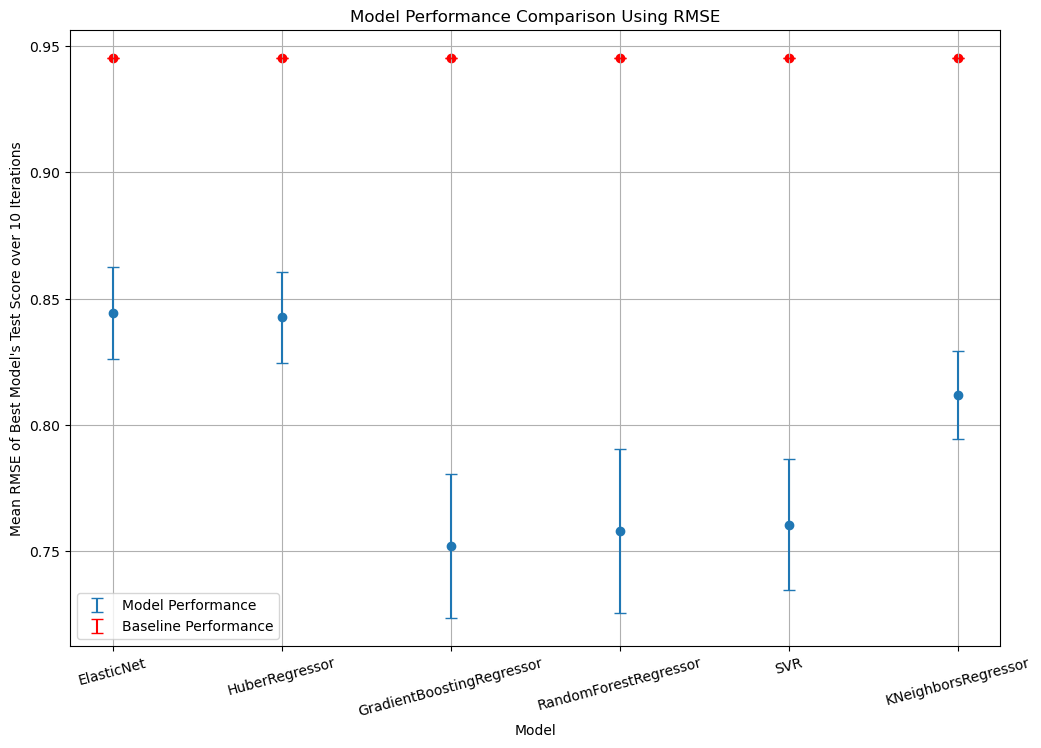

In [37]:
plt_4 = plt.figure(figsize=(12, 8))
plt.errorbar(model_perf_dict.keys(), np.array(list(model_perf_dict.values()))[:, 0], 
             yerr=np.array(list(model_perf_dict.values()))[:, 1], capsize=4, fmt='none', label='Model Performance')

plt.errorbar(model_bsl_perf_dict.keys(), np.array(list(model_bsl_perf_dict.values()))[:, 0], 
             yerr=np.array(list(model_bsl_perf_dict.values()))[:, 1], capsize=4, fmt='none', color='r', 
             label='Baseline Performance')

plt.scatter(model_perf_dict.keys() , np.array(list(model_perf_dict.values()))[:, 0])
plt.scatter(model_bsl_perf_dict.keys() , np.array(list(model_bsl_perf_dict.values()))[:, 0], color='r')
plt.grid()
plt.title('Model Performance Comparison Using RMSE')
plt.xlabel('Model')
plt.ylabel('Mean RMSE of Best Model\'s Test Score over 10 Iterations')
plt.xticks(rotation=15)
plt.legend()
plt.savefig('Figures/Model_performance_rmse.png', dpi=300)
plt.show()

In [38]:
model_stats = pd.DataFrame.from_dict(perf_dicts[0], orient='index', columns=['Mean Test Score', 'Test Score Std Dev'])
model_stats['Mean Baseline'] = np.array(list(model_bsl_perf_dict.values()))[:, 0]
model_stats.sort_values(by='Mean Test Score')#['Mean Test Score']

,Mean Test Score,Test Score Std Dev,Mean Baseline
GradientBoostingRegressor,0.752121,0.028509,0.945257
RandomForestRegressor,0.758145,0.032391,0.945257
SVR,0.760472,0.025891,0.945257
KNeighborsRegressor,0.811875,0.017423,0.945257
HuberRegressor,0.842605,0.018011,0.945257
ElasticNet,0.844238,0.018250,0.945257


### Evaluate Optimal Models Based on Test Set Used 

ElasticNet
RMSE: 0.830907557665051
RMSE Baseline: 0.9452570033959737


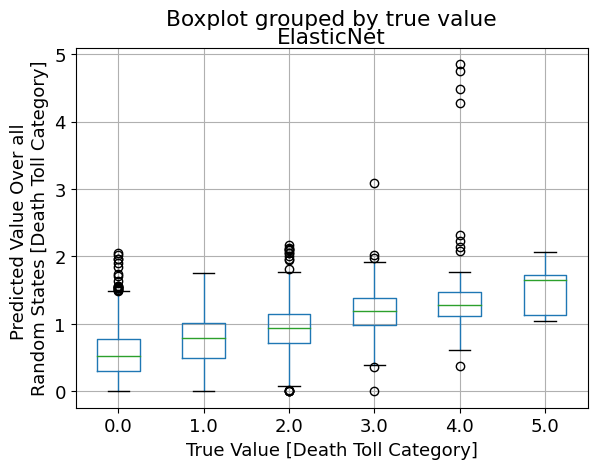

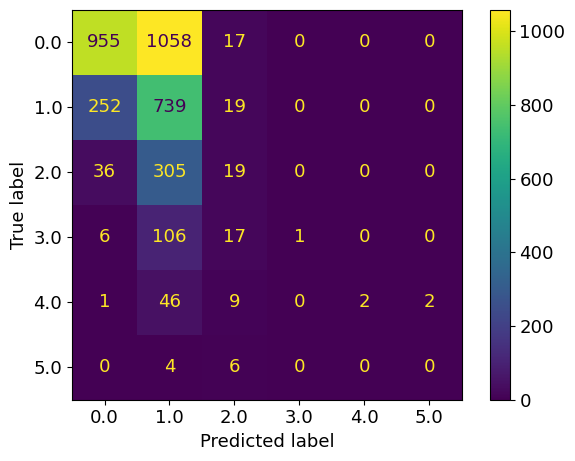

HuberRegressor
RMSE: 0.831180516291666
RMSE Baseline: 0.9452570033959737


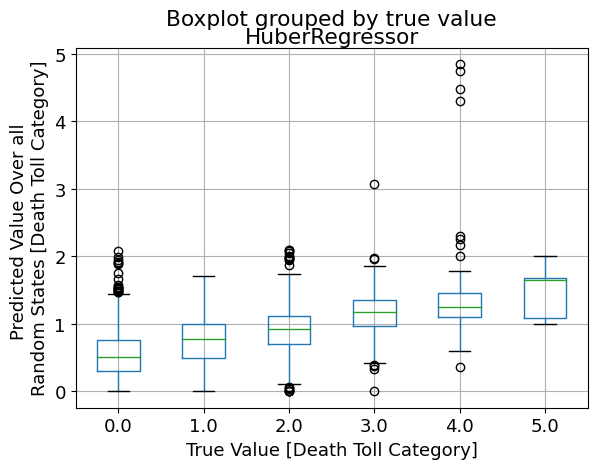

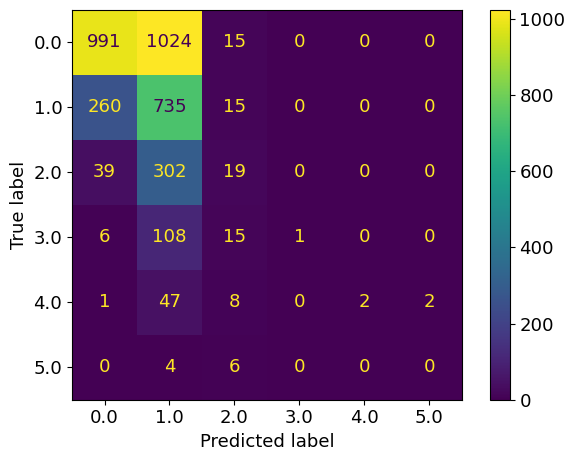

GradientBoostingRegressor
RMSE: 0.7519838188390756
RMSE Baseline: 0.9452570033959737


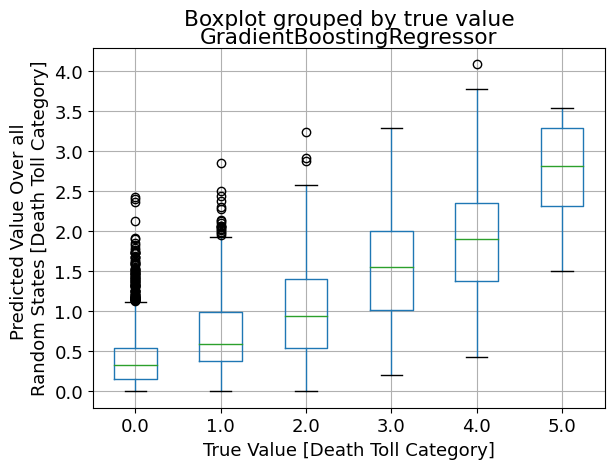

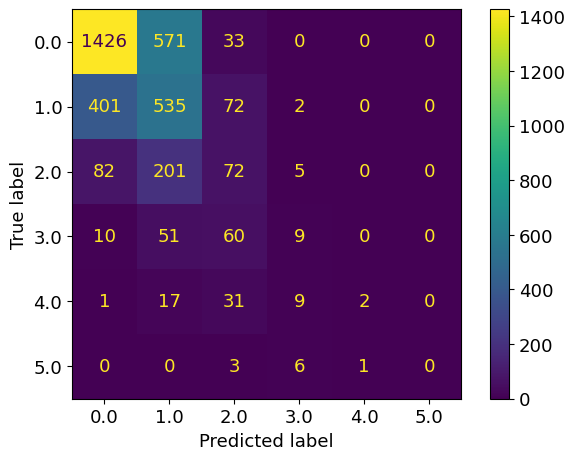

RandomForestRegressor
RMSE: 0.7588370870739262
RMSE Baseline: 0.9452570033959737


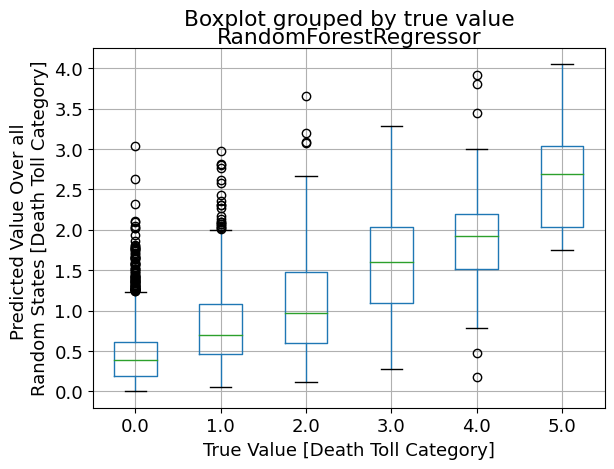

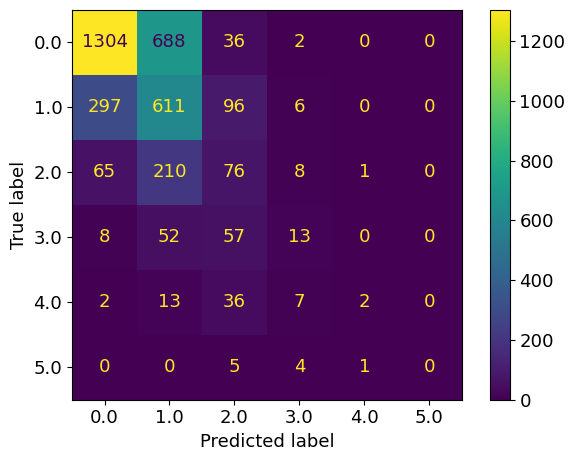

SVR
RMSE: 0.7559036058976134
RMSE Baseline: 0.9452570033959737


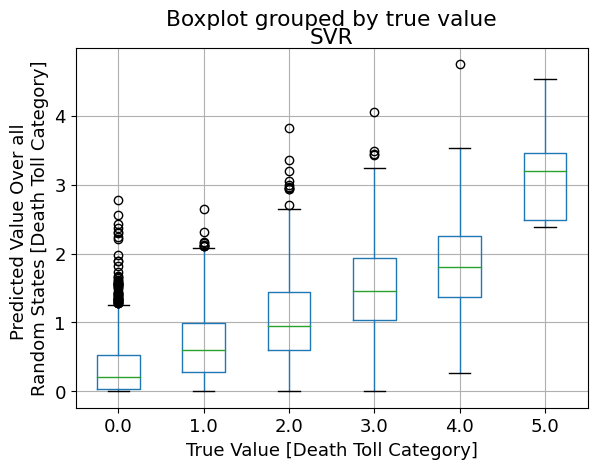

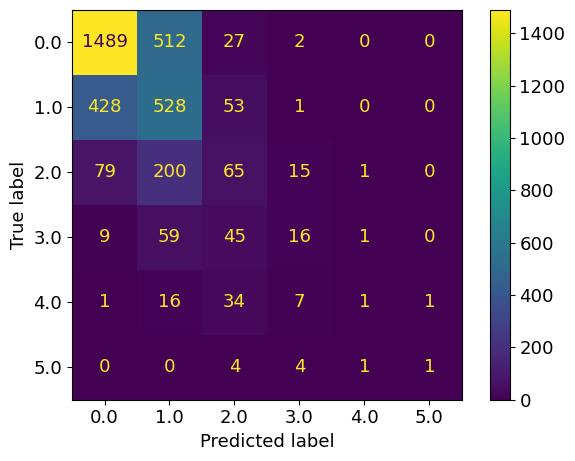

KNeighborsRegressor
RMSE: 0.8120615416163063
RMSE Baseline: 0.9452570033959737


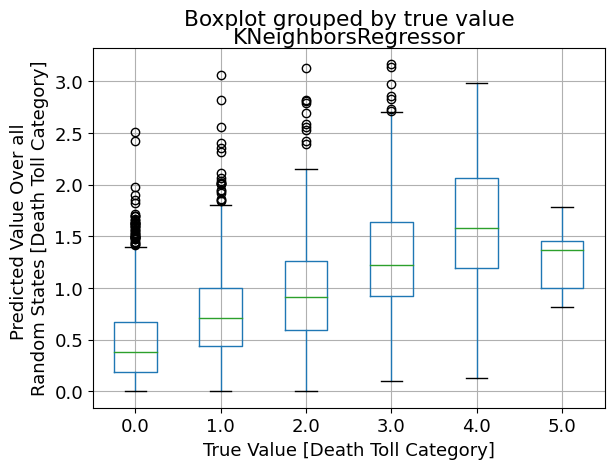

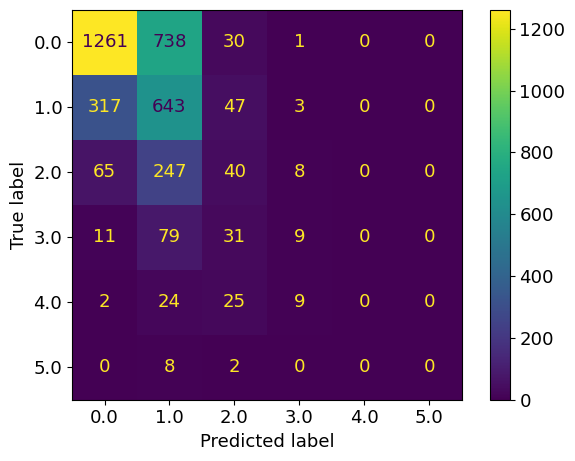

In [121]:
for model_type, model_list in model_dict.items():
    all_preds = []
    all_true = []
    for r_state, model in enumerate(model_list):
        x_other, x_test, y_other, y_test = train_test_split(feature_matrix, target_var, test_size=0.2, 
                                                            random_state=r_state, stratify=target_var)

        prds = model.predict(x_test)
        prds = np.where(prds < 0, 0, prds)
        all_preds.extend(list(prds))
        all_true.extend(list(y_test))
    tdf = pd.DataFrame()
    tdf['true value'] = all_true
    tdf['pred'] = all_preds
    tdf[['true value', 'pred']].boxplot(by='true value')
    
    y_hat_rmse = [np.mean(all_true)] * len(all_true)
    plt.title(model_type, pad=0)
    avg_pred_rounded = np.round(all_preds)
    plt.xlabel('True Value [Death Toll Category]')
    plt.ylabel('Predicted Value Over all \nRandom States [Death Toll Category]')
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(all_true, avg_pred_rounded)
    print(model_type)
#     print('F1 Weighted:', f1_score(all_true, avg_pred_rounded, average='macro'))
#     print('F1 Weighted Baseline:', f1_score(all_true, y_hat_acc, average='weighted'))
#     print('Acc:', accuracy_score(all_true, np.round(all_preds)))
    print('RMSE:', rmse(all_true, all_preds))
    print('RMSE Baseline:', rmse(all_true, y_hat_rmse))
    plt.tight_layout()

#     plt.savefig(f'Figures/{model_type}_predictions.png', dpi=300)

    plt.show()

In [6]:
# for model_type, model_list in model_dict.items():
#     all_preds = pd.DataFrame()
#     all_true = []
#     for r_state, model in enumerate(model_list):
#         prds = model.predict(x_hld)
#         prds = np.where(prds < 0, 0, prds)
#         all_preds[f'pred_{r_state}'] = prds
#     all_preds['group_pred'] = all_preds.mean(axis=1)
#     all_preds['true value'] = y_hld.reset_index(drop=True)
#     all_preds[['true value', 'group_pred']].boxplot(by='true value')
    
#     y_hat_rmse = [np.mean(y_hld)] * len(y_hld)
#     plt.title(model_type, pad=0)
#     avg_pred_rounded = np.round(all_preds['group_pred'])
#     plt.xlabel('True Value [Death Toll Category]')
#     plt.ylabel('Predicted Value Over all \nRandom States [Death Toll Category]')
#     ConfusionMatrixDisplay(confusion_matrix).from_predictions(y_hld, avg_pred_rounded)
#     print(model_type)
# #     print('F1 Weighted:', f1_score(all_true, avg_pred_rounded, average='macro'))
# #     print('F1 Weighted Baseline:', f1_score(all_true, y_hat_acc, average='weighted'))
# #     print('Acc:', accuracy_score(all_true, np.round(all_preds)))
#     print('RMSE:', rmse(y_hld, all_preds['group_pred']))
#     print('RMSE Baseline:', rmse(y_hld, y_hat_rmse))
    
#     plt.show()

## Feature Importance

In [27]:
chosen_model = model_dict['GradientBoostingRegressor'][2].best_estimator_
feature_names = chosen_model[0].get_feature_names_out()

### Local Importance

In [41]:
# Loading models
for idx, model in enumerate(model_dict['GradientBoostingRegressor']):
    with open(f'Results/model_{idx}.save', 'wb') as file:
        pickle.dump(model, file)

In [5]:
# Importing models
model_list = []
for idx in range(10):
    with open(f'Results/model_{idx}.save', 'rb') as file:
        model_list.append(pickle.load(file))


In [43]:
shap_dict = {}
for idx, mdl in enumerate(model_list):
    chosen_model = mdl.best_estimator_

    x_other, x_test, y_other, y_test = train_test_split(feature_matrix, target_var, test_size=0.2, 
                                                                random_state=idx, stratify=target_var)
    explainer = shap.TreeExplainer(chosen_model[1])
    feature_names = chosen_model[0].get_feature_names_out()
    y_test = y_test.reset_index(drop=False)
    X_test_transformed = pd.DataFrame(np.round(chosen_model[0].transform(x_test), 3), columns=feature_names, index=y_test['index'])
        
    shap_values = pd.DataFrame(explainer.shap_values(X_test_transformed), columns = feature_names, index=y_test['index'])
    
    shap_dict[idx] = [X_test_transformed, explainer, shap_values, y_test, chosen_model, feature_names, x_test]

In [108]:
dfs = []
for idx, data in shap_dict.items():
    rdf = data[6].reset_index(drop=True).copy()
    rdf['diff'] = data[3]['Deaths_Logged_Category'] - data[4][1].predict(data[0])
    rdf['target'] = data[3]['Deaths_Logged_Category']
    rdf['pred'] = data[4][1].predict(data[0])
    rdf['orig_idx'] = data[3]['index']
    rdf.sort_values(by='diff')
    dfs.append(rdf)

all_preds = pd.concat(dfs)
pred_agg = all_preds.groupby(['target', 'orig_idx']).agg(avg_diff=('diff', 'mean'),
                                                         std_diff=('diff', 'std'),
                                                         ct=('diff', 'count'),
                                                         pred=('pred', 'mean')).reset_index()
pred_agg.sort_values(by='avg_diff', key=lambda x: np.abs(x), ascending=False).head(15)

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without featur

,target,orig_idx,avg_diff,std_diff,ct,pred
1557,4.0,182,3.567583,NaN,1,0.432417
1562,4.0,441,3.294609,NaN,1,0.705391
1578,5.0,401,3.173080,0.333782,3,1.826920
1563,4.0,473,2.943488,0.027631,4,1.056512
1576,4.0,1692,2.880744,0.206706,3,1.119256
1534,3.0,1277,2.797463,NaN,1,0.202537
1570,4.0,694,2.745305,0.144055,3,1.254695
1500,3.0,57,2.705274,NaN,1,0.294726
1513,3.0,379,2.686753,0.053187,5,0.313247
1502,3.0,79,2.673844,0.047847,2,0.326156


ACTUAL MAGNITUDE: 4.0
                                          Model Generated with Random State #1


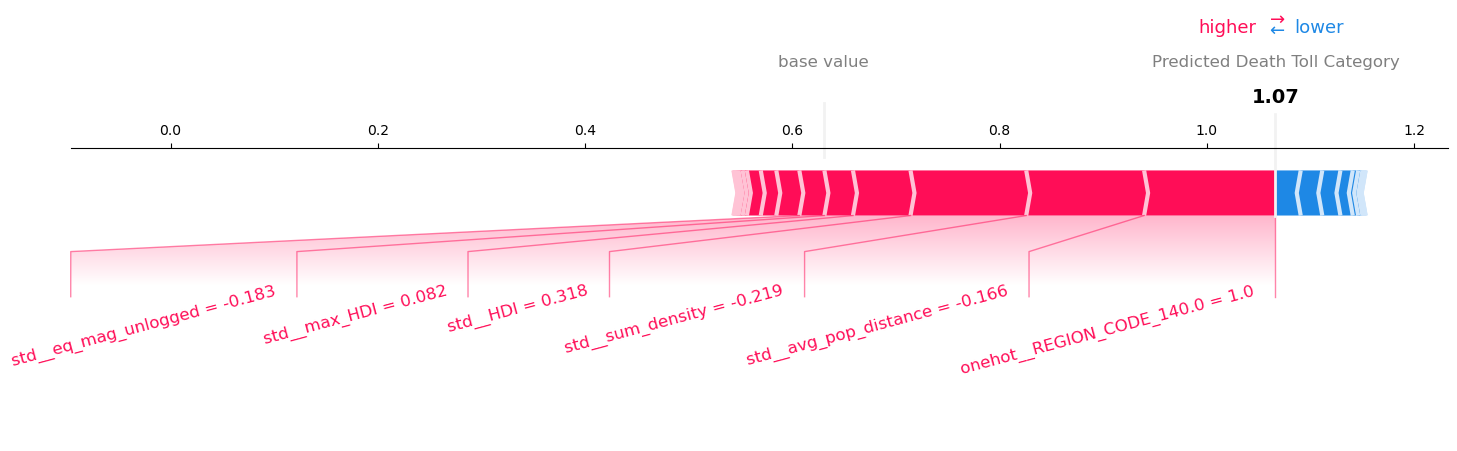

                                          Model Generated with Random State #3


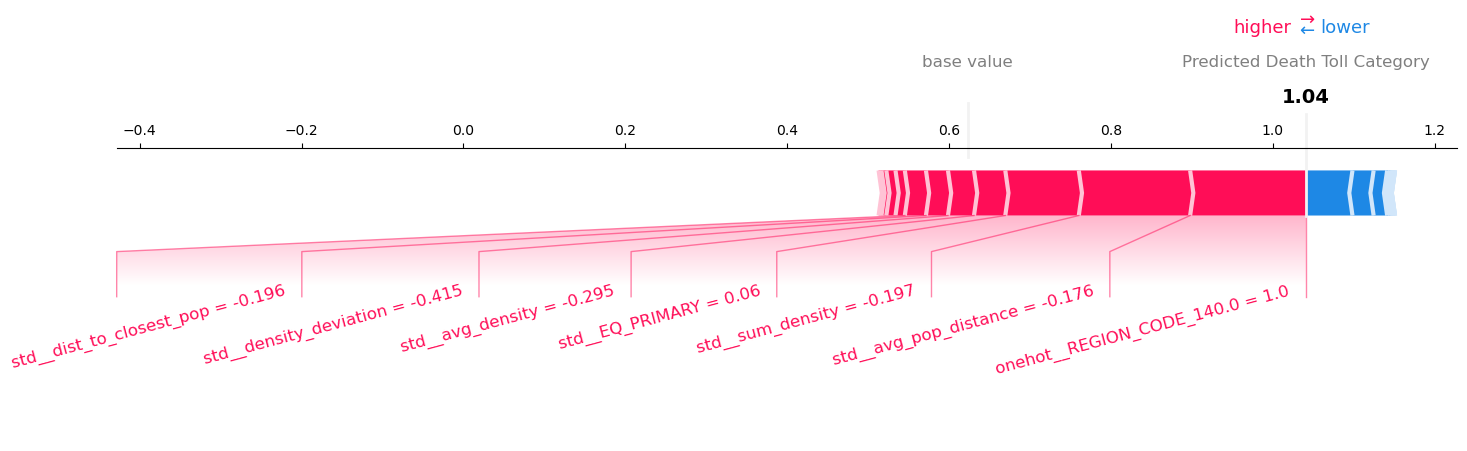

                                          Model Generated with Random State #5


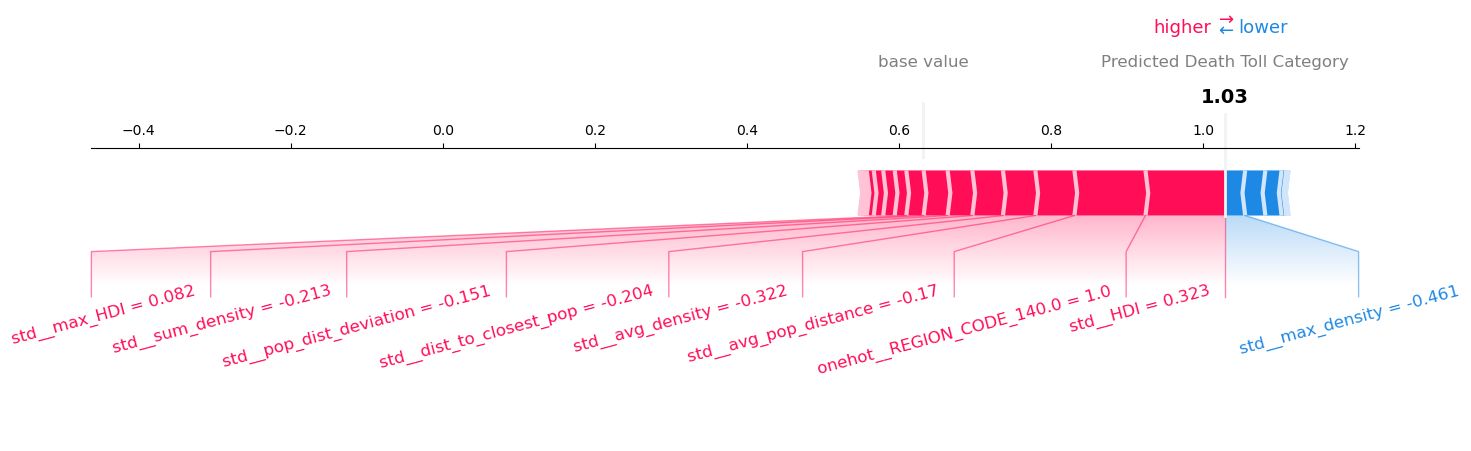

                                          Model Generated with Random State #7


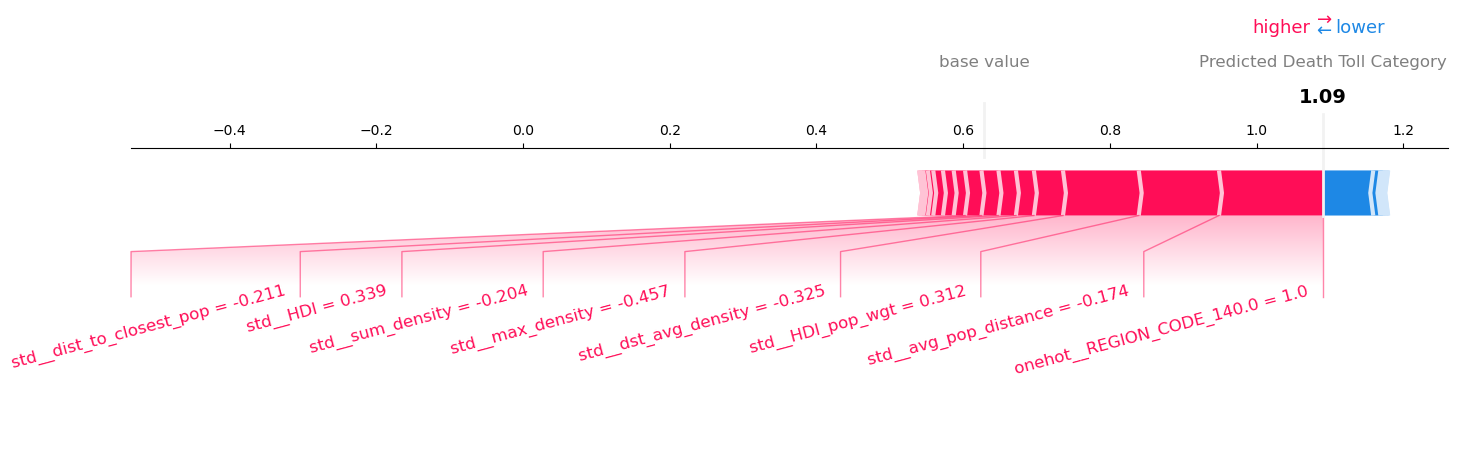

In [109]:
index = 473

y_true = pred_agg[pred_agg['orig_idx'] == index].values[0][0]
print(f'ACTUAL MAGNITUDE: {y_true}')

for idx, data in shap_dict.items():
    
    if (data[3][data[3]['index'] == index].values).any():
#         print(data[1].expected_value[0])

        print(f'                                          Model Generated with Random State #{idx}')
        shap.force_plot(data[1].expected_value[0], 
                        data[2][data[2].index.isin([index])].values, 
                        features = data[0][data[0].index.isin([index])].values, 
                        feature_names = data[5], 
                        out_names='Predicted Death Toll Category',
                        matplotlib=True, figsize=(15, 5), text_rotation=15, show=False)
        plt.tight_layout()
#         plt.savefig(f'Figures/GBR_{index}_rst_{idx}.png', dpi=300)
        plt.show()

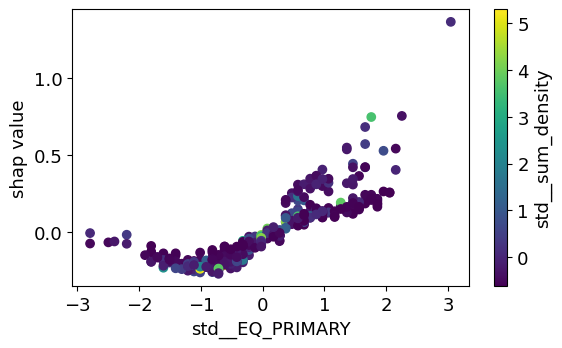

In [122]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
ftr = 'std__EQ_PRIMARY'
ftr2 = 'std__sum_density'
indx = np.argwhere(feature_names==ftr)
indx2 = np.argwhere(feature_names==ftr2)

plt.figure(figsize=(6.4,3.6))
plt.scatter(shap_dict[7][0][ftr],shap_dict[7][2][ftr], c=shap_dict[7][0][ftr2])
plt.ylabel('shap value')
plt.xlabel(ftr)
plt.colorbar(label=ftr2)
plt.show()

### Global Importance

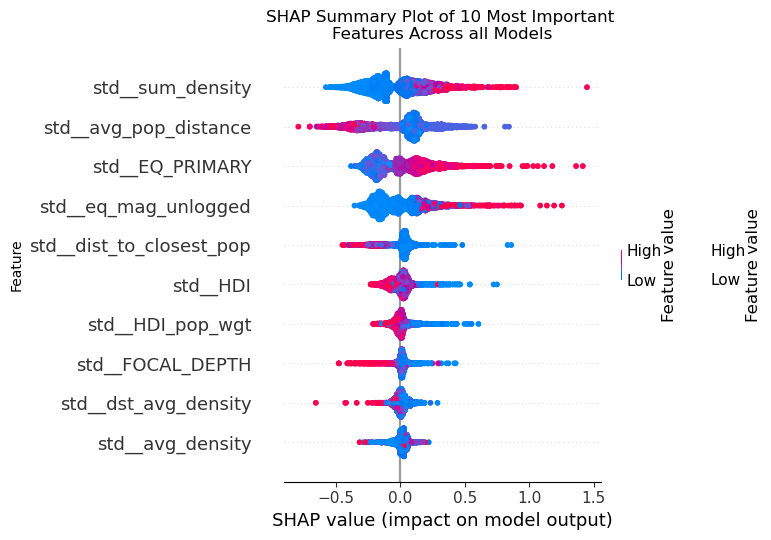

In [105]:
# Shap Summary Plot
# [X_test_transformed, explainer, shap_values, y_test, chosen_model, feature_names, x_test]

all_shaps = pd.concat([data[2] for data in shap_dict.values()]).reset_index(drop=True).fillna(0)
all_data = pd.concat([data[0] for data in shap_dict.values()]).reset_index(drop=True).fillna(0)
shap.summary_plot(all_shaps.values, all_data.values, feature_names = all_data.columns, max_display=10, show=False)
plt.title('SHAP Summary Plot of 10 Most Important \nFeatures Across all Models')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(f'Figures/GradientBoostingRegressor_Shap_Summary_All_Models.png', dpi=300)

In [113]:
def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", vert=False,  figsize=(10, 8))

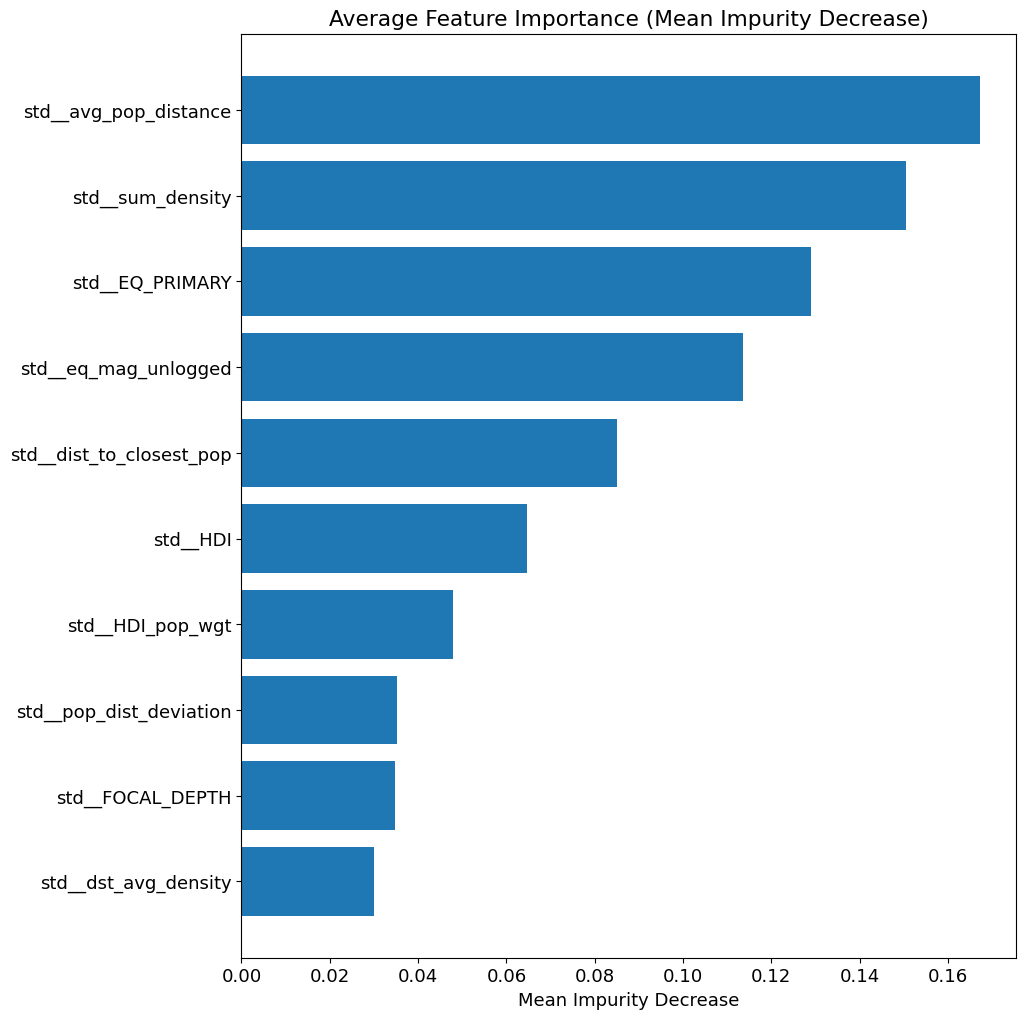

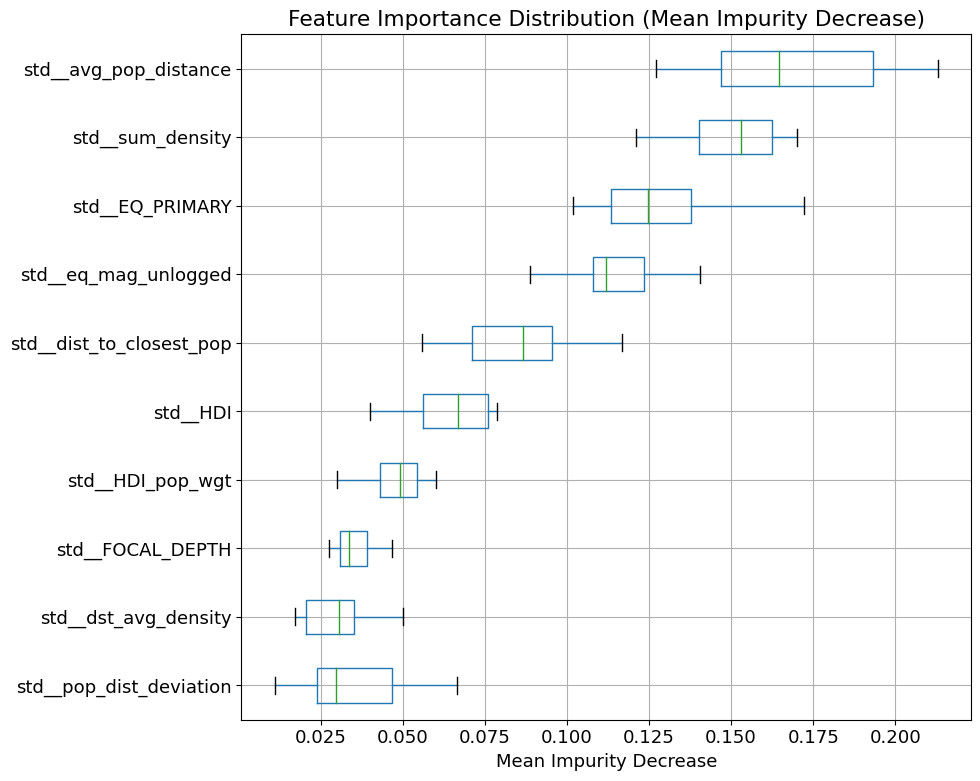

In [49]:
# Feature Importances from Model- Mean Impurity Decrease. Averaged over all rstates
num_ftrs = 10

plt_5 = plt.figure(figsize=(10, 12))
total_importance = []
for data in shap_dict.values():
    chosen_model = data[4]
    total_importance.append(pd.DataFrame(chosen_model[1].feature_importances_.reshape(-1, len(data[5])), 
                                         columns = data[5]))

all_imps = pd.concat(total_importance)
avg_imp = all_imps.mean()
avg_imp.sort_values(ascending=True, inplace=True)
importances = all_imps.melt( var_name='Feature', value_name='Importance')
top_importances = importances[importances['Feature'].isin(avg_imp.index[-num_ftrs:].to_list())]
plt.barh(width=avg_imp.values[-num_ftrs:], y=avg_imp.index[-num_ftrs:])
plt.title('Average Feature Importance (Mean Impurity Decrease)')
plt.xlabel('Mean Impurity Decrease')

plt.show()
boxplot_sorted(top_importances, 'Feature', 'Importance')
plt.title('Feature Importance Distribution (Mean Impurity Decrease)')
plt.xlabel('Mean Impurity Decrease')
plt.tight_layout()
plt.savefig(f'Figures/GradientBoostingRegressor_Impurity_Importance.png', dpi=300)


plt.show()

In [111]:
# Feature Permutation
np.random.seed(42)
total_prm_importance = []
nr_runs = 10
ftr_names = x_test.columns
tst_scrs = []
for idx, data in shap_dict.items():
    scores = np.zeros([len(ftr_names), nr_runs])

    test_score = rmse(data[3].iloc[:, 1], data[4].predict(data[6]))
    tst_scrs.append(test_score)
    y_hat_rmse = [np.mean(data[3].iloc[:, 1])] * len(y_test)
#     print('test score = ', test_score)
#     print('test baseline = ',rmse(data[3].iloc[:, 1], y_hat_rmse))
    # loop through the features
    for i in range(len(ftr_names)):
    #     print('shuffling '+str(ftr_names[i]))
        acc_scores = []
        for j in range(nr_runs):
            x_test_shuffled = data[6].copy()
            x_test_shuffled[ftr_names[i]] = np.random.permutation(data[6][ftr_names[i]].values)
            acc_scores.append(rmse(data[3].iloc[:, 1], data[4].predict(x_test_shuffled)))
    #     print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
        scores[i] = acc_scores
    total_prm_importance.append(scores)

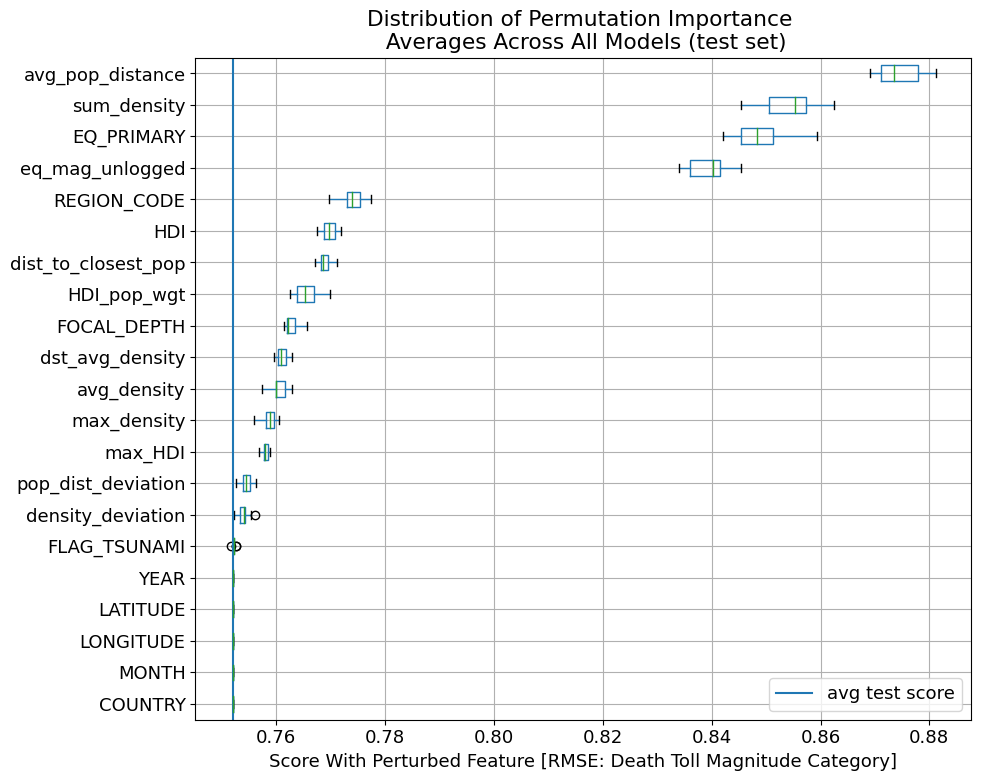

In [115]:
all_states_prt = [pd.DataFrame(imp.T, columns=feature_matrix.columns) for imp in total_prm_importance]
avg_change = sum(all_states_prt) / len(all_states_prt)

avg_test_score = np.mean(tst_scrs)

num_ftrs = 21

avg_chg = avg_change.mean()
avg_chg.sort_values(ascending=True, inplace=True)
chgs = avg_change.melt( var_name='variable', value_name='value')
top_chgs = chgs[chgs['variable'].isin(avg_chg.index[-num_ftrs:].to_list())]

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(10,8))
boxplot_sorted(top_chgs, 'variable', 'value')
plt.axvline(avg_test_score,label='avg test score')

plt.title("Distribution of Permutation Importance \n Averages Across All Models (test set)")
plt.xlabel('Score With Perturbed Feature [RMSE: Death Toll Magnitude Category]')

plt.legend()
plt.tight_layout()
# plt.savefig(f'Figures/GradientBoostingRegressor_Feature_Permutation.png', dpi=300)
plt.show()

In [42]:
avg_test_score

0.7521212477953723

## Export to Map

In [ ]:
# [X_test_transformed, explainer, shap_values, y_test, chosen_model, feature_names, x_test]
for idx, data in shap_dict.items():
#     preds = 
    data[3]

In [ ]:
data[6].columns#.iloc[:, 1]

In [ ]:
all_preds

In [ ]:
test_results = all_preds.groupby(list(all_preds.columns[:-4])).agg(avg_diff=('diff', 'mean'),avg_pred=('pred', 'mean'),
                                                    ct=('diff', 'count'), actual=('target', 'mean')).reset_index()

In [ ]:
test_results.to_csv('Data/boosted_reg_results.csv')

In [ ]:
cm_bright = ListedColormap(test_results['ct'])
cm = plt.cm.RdBu
test_results[['actual', 'avg_pred']].boxplot(by='actual', figsize=(10,10))
plt.show()

In [ ]:
avg_pred_rounded = np.round(test_results['avg_pred'])
ConfusionMatrixDisplay(confusion_matrix).from_predictions(test_results['actual'], avg_pred_rounded)